# Worm - Text Mining

## Table Of Contents:

* [Crawling](#bullet1)
* [Cleaning](#bullet2)
* [Descriptive Analysis](#bullet3)
* [TFIDF](#bullet4)


Preambel

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re, math
import seaborn as sns
from bs4 import BeautifulSoup
import urllib

from stop_words import get_stop_words

In [2]:
#Notebook options
%matplotlib inline
sns.set_style("whitegrid")
matplotlib.rcParams['figure.figsize'] = [15,5]

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

## Crawling <a class="anchor" id="bullet1"></a>  

In [20]:
%%time
title = 'Wormy'
url = 'https://parahumans.wordpress.com/category/stories-arcs-1-10/arc-1-gestation/1-01/'
wormdata = pd.DataFrame(columns=('Heading', 'Text'))
while title != 'Interlude: End':
    # open link and save the info into wormdata
    link = urllib.request.urlopen(url.replace('\xbd', '&#xBD')).read()
    soup = BeautifulSoup(link)
    title = soup.find("h1",  class_="entry-title").text
    text = soup.find('div', class_="entry-content").text.strip()
    wormdata = wormdata.append(pd.DataFrame({'Heading': [title], 'Text': [text]}), ignore_index=True)
    
    # get to next chapter which is weirdly done in three different ways
    url1 = soup.find('a', title="Next Chapter")
    url2 = soup.find('a', text='Next Chapter')
    url3 = soup.find('a', text=' Next Chapter')
    if url1:
        url = soup.find('a', title="Next Chapter").attrs['href']
    if url2:
        url = soup.find('a', text='Next Chapter').attrs['href']
    if url3:
        url = soup.find('a', text=' Next Chapter').attrs['href']


#re.findall('.+Next\sChapter\n(.+)\nLast\sChapter.+', x, re.DOTALL)[0].strip() if x[1]!='e' and x[121:124]!='End' else re.findall('.*Next\sChapter\n(.+)\nNext\sChapter.*', x, re.DOTALL)[0].strip() if x[1]=='e' else re.findall('.*\xa0\xa0\ End\n(.+)\nLast\sChapter.*', x, re.DOTALL)[0].strip()

CPU times: user 1min 8s, sys: 2.02 s, total: 1min 10s
Wall time: 7min 54s


In [24]:
# extract chapter text from raw text accounting for two special cases
def getText(x): 
    if x[1]=='e':
        return re.findall('.*Next\sChapter\n(.+)\nNext\sChapter.*', x, re.DOTALL)[0].strip()
    elif (x[1]!='e' and x[121:124]!='End'):
        return re.findall('.+Next\sChapter\n(.+)\nLast\sChapter.+', x, re.DOTALL)[0].strip() 
    else:  
        return re.findall('.*\xa0\xa0\ End\n(.+)\nLast\sChapter.*', x, re.DOTALL)[0].strip()
               
wormdata['Text'] = wormdata['Text'].apply(getText)

In [25]:
wormdata.head()

,Heading,Text
0,Gestation 1.1,Brief note from the author: This story isn’t ...
1,Gestation 1.2,My thoughts were on Emma on the bus ride home....
2,Gestation 1.3,My training schedule consisted of running ever...
3,Gestation 1.4,I felt a chill. A part of me really wished th...
4,Gestation 1.5,You don’t properly appreciate what superhuman ...


## Cleaning <a class="anchor" id="bullet2"></a>  

In [26]:
#Add columns for number of letters, super- and subchapter (arc, chapter), and section (both combined)
def floating(x):
    if re.findall("\d+\.*\d*",x)!=[]:
        return re.findall("\d+\.*\d*",x)[0]
    else:
        return 0
    
wormdata['Letters'] = wormdata['Text'].apply(len)
wormdata['Section'] = wormdata['Heading'].apply(floating)
wormdata['Arc'] = wormdata['Heading'].apply(lambda x: math.trunc(float(floating(x))))
wormdata['Chapter'] = wormdata['Heading'].apply(lambda x: re.findall("\.(\d*).*",str(floating(x)))[0] if re.findall("\.(\d*).*",str(floating(x)))!=[] else 0)

In [27]:
# Fix epilogue as chapter 31
for i in range(298,304):
    x = i-297
    wormdata.at[i, 'Section'] = "31." + str(x)
    wormdata.at[i, 'Chapter']  = str(x)
    wormdata.at[i, 'Arc'] =  31
wormdata.at[36, 'Arc'] = 4

In [28]:
# Get the chapter heading
wormdata['Heading'] = wormdata['Heading'].apply(lambda x: x.replace(':', ' ').split(' ')[0])

In [29]:
# Fix the interludes
wormdata['InterludeNr'] = '0'
wormdata['Interlude'] = False
heading = 'Wormy'
interludecount=0
for i,chapter in enumerate(wormdata['Heading']):
    if chapter == 'Interlude':
        wormdata.at[i, 'Interlude'] =  True
        wormdata.at[i, 'InterludeNr'] = 'abcdefghijk'[interludecount]
        wormdata.at[i, 'Heading'] = heading
        chapter= heading
        interludecount += 1
        lastinterlude = i
    if chapter != heading:
        if interludecount==1:
            wormdata.at[lastinterlude, 'InterludeNr'] = ''
        interludecount=0
    heading = chapter

In [30]:
# Fix weird symbols in the text
wormdata['Text'] = wormdata['Text'].apply(lambda x: x.replace(' ',' ').replace('  ',' '))

In [31]:
wormdata.head()

,Heading,Text,Letters,Section,Arc,Chapter,InterludeNr,Interlude
0,Gestation,Brief note from the author: This story isn’t i...,15972,1.1,1,1,0,False
1,Gestation,My thoughts were on Emma on the bus ride home....,12140,1.2,1,2,0,False
2,Gestation,My training schedule consisted of running ever...,10550,1.3,1,3,0,False
3,Gestation,I felt a chill. A part of me really wished tha...,11598,1.4,1,4,0,False
4,Gestation,You don’t properly appreciate what superhuman ...,14479,1.5,1,5,0,False


In [32]:
wormdata.to_csv('wormdata.csv', index=False)

In [65]:
wormdata = pd.read_csv('wormdata.csv', dtype={'Section': str})

## Descriptive Analysis <a class="anchor" id="bullet3"></a> 

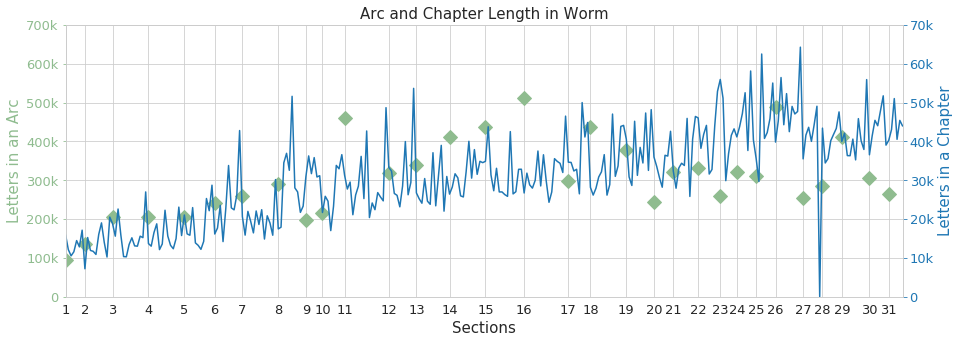

In [74]:
fig, ax1 = plt.subplots()
wormdata[['Letters', 'Arc']].groupby('Arc').sum().set_index([wormdata.index[wormdata['Chapter']==1].tolist()])\
.plot(ax=ax1, color='darkseagreen', legend=False, marker='D', linewidth=0, markersize=10)
ax1.set_ylim((0,700000))
ax1.set_ylabel('Letters in an Arc', color='darkseagreen')
ax1.set_xticks(wormdata.index[wormdata['Chapter']==1].tolist())
ax1.set_xticklabels(wormdata['Arc'][wormdata['Chapter']==1])
ax1.set_yticklabels(['0', '100k', '200k', '300k', '400k', '500k', '600k', '700k'])
ax1.set_xlabel('Sections')
ax1.set_title('Arc and Chapter Length in Worm')
ax1.tick_params('y', colors='darkseagreen')

ax2 = ax1.twinx()
wormdata['Letters'].plot(ax=ax2,grid=False)
ax2.tick_params('y', colors=sns.color_palette()[0])
ax2.set_ylim((0,70000))
ax2.set_yticklabels(['0', '10k', '20k', '30k', '40k', '50k', '60k', '70k'])
ax2.set_ylabel('Letters in a Chapter', color=sns.color_palette()[0])
plt.show()

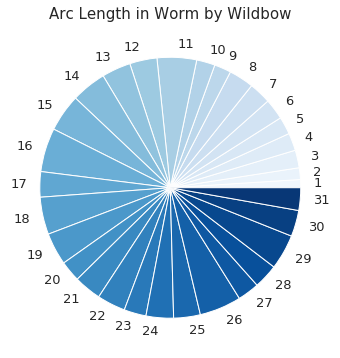

In [75]:
plt.figure(figsize=(6,6))
labels = set(wormdata['Arc'])
colors = sns.color_palette("Blues", 31)
plt.pie(wormdata[['Letters','Arc']].groupby('Arc').sum()['Letters'], labels=labels, colors=colors)
plt.title('Arc Length in Worm by Wildbow')
plt.show()

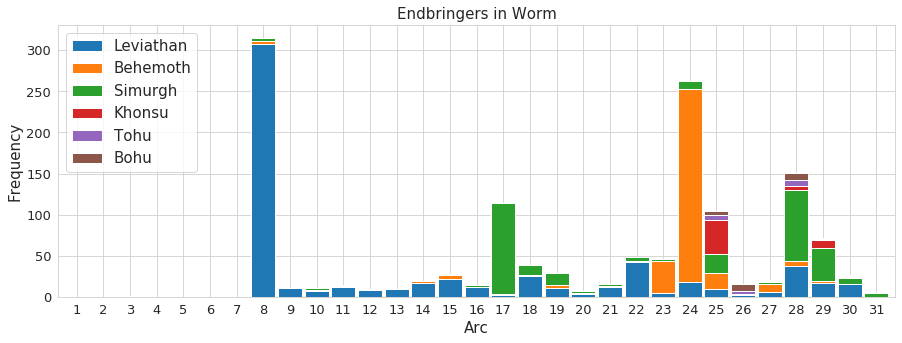

In [76]:
endbringers = ['Leviathan', 'Behemoth', 'Simurgh', 'Khonsu', 'Tohu', 'Bohu']
for endbringer in endbringers:
    wormdata[endbringer] = wormdata['Text'].apply(lambda x: len(re.findall(endbringer, x)))

wormdata[endbringers + ['Arc']].groupby('Arc').sum().plot(kind='bar', stacked=True, figsize=(15,5), width=0.9)
plt.xticks(range(31), range(1,32), rotation='horizontal')
plt.title('Endbringers in Worm')
plt.ylabel('Frequency')
plt.xlabel('Arc')
plt.legend(loc='upper left')
plt.show()

## TFIDF <a class="anchor" id="bullet4"></a>  

In [66]:
wormdata = pd.read_csv('wormdata.csv', dtype={'Section': str})

In [67]:
# bag of words
def getBag(text):
    return [re.sub(r'[^a-zA-Z]+', '', y).lower() for y in text.replace('\n',' ').split(' ')]

mininglist = wormdata['Text'].apply(getBag)

In [68]:
# remove stopwords
def removeStopwords(words):
    stopWords = set([re.sub(r'[^a-zA-Z]+', '', x).lower() for x in get_stop_words('en')])
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

cleaned_mininglist = mininglist.apply(removeStopwords)

In [69]:
# get text format again
miningtext = [' '.join(clean_list) for clean_list in cleaned_mininglist]

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(miningtext)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

tfidf = pd.DataFrame(denselist, columns=feature_names)

In [72]:
tfidf

,aaand,aabbout,aah,aahheuuhhhmmm,aangebied,aarde,aasdier,ab,ababbboutt,aback,...,zones,zoning,zoo,zoom,zoomed,zoomedin,zooming,zooms,zucchini,zwt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
for index, row in tfidf.iterrows():
    top_words = row.sort_values(ascending=False)[:5].index.tolist()
    print(str(wormdata['Section'][index]) + ": ", top_words)

1.1:  ['madison', 'class', 'lunch', 'mr', 'girls']
1.2:  ['notebook', 'coal', 'spiders', 'costume', 'chute']
1.3:  ['gang', 'lung', 'people', 'boardwalk', 'gangsters']
1.4:  ['lung', 'fire', 'bee', 'stinger', 'swarm']
1.5:  ['roof', 'lung', 'flame', 'spray', 'fire']
1.6:  ['armsmaster', 'said', 'credit', 'lung', 'capture']
1:  ['danny', 'daughter', 'taylor', 'temper', 'bullies']
2.1:  ['dad', 'toast', 'french', 'night', 'said']
2.2:  ['wiki', 'search', 'page', 'assignment', 'message']
2.3:  ['gladly', 'greg', 'mr', 'julia', 'madison']
2.4:  ['emma', 'girls', 'just', 'emmas', 'madison']
2.5:  ['library', 'message', 'proof', 'rebug', 'tattletale']
2.6:  ['lisa', 'brian', 'alec', 'lung', 'said']
2.7:  ['lisa', 'alec', 'brian', 'couch', 'loft']
2.8:  ['brian', 'dogs', 'bitch', 'rottweiler', 'terrier']
2.9:  ['alec', 'brian', 'lisa', 'dad', 'said']
2:  ['victoria', 'amy', 'sister', 'just', 'skinhead']
3.1:  ['brian', 'sophia', 'just', 'school', 'boardwalk']
3.2:  ['alec', 'brian', 'boardwal

15.6:  ['flechette', 'parian', 'said', 'armsmaster', 'spike']
15.7:  ['brooks', 'sierra', 'bryce', 'socket', 'said']
15:  ['alexandria', 'rebecca', 'doctor', 'legend', 'eidolon']
15.8:  ['trickster', 'rory', 'genesis', 'mayor', 'bugs']
15.9:  ['triumph', 'prism', 'bugs', 'mayor', 'triumphs']
15.10:  ['atlas', 'said', 'sling', 'coil', 'mayors']
15:  ['triumph', 'militia', 'assault', 'miss', 'prism']
16.1:  ['drones', 'grue', 'said', 'dragon', 'coil']
16.2:  ['trickster', 'grue', 'suits', 'wheel', 'bugs']
16:  ['evan', 'squad', 'rinke', 'holler', 'tieu']
16.3:  ['director', 'tattletale', 'said', 'trickster', 'grue']
16.4:  ['suit', 'biter', 'barker', 'suits', 'shatterbird']
16.5:  ['azazel', 'drones', 'suit', 'imp', 'bentley']
16.6:  ['said', 'grue', 'imp', 'sierra', 'way']
16:  ['code', 'sheriff', 'hookwolf', 'colin', 'data']
16.7:  ['kurt', 'lacey', 'dad', 'said', 'beer']
16.8:  ['mayor', 'circus', 'coil', 'grove', 'auditorium']
16.9:  ['paramedic', 'dad', 'coil', 'reporters', 'mayor']